In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from plottingutils import *

dir_ = '../results/'
files = os.listdir(dir_ )
files = [f for f in files if f[-4:] == '.pkl']

dfs = []
for f in files:
    tmp = pd.read_pickle(dir_+f)
    dfs.append(tmp)
result_df = pd.concat(dfs, ignore_index=True)
result_df.rename(columns={"Description":"Model"}, inplace=True)

In [2]:
result_df

,Model,Accuracy,Precision,Recall,F1-score
0,NBw2vgoog_val,0.548778,0.137194,0.250000,0.177165
1,LRw2vgoog_val,0.865571,0.780205,0.746949,0.758249
2,LRw2vgoogCWbal_val,0.838469,0.734362,0.797831,0.750896
3,LRw2vgoogCWgscv_val,0.842182,0.735224,0.793478,0.754493
4,LRw2vgoogUnder_val,0.833549,0.729796,0.795515,0.746056
5,LRw2vgoogOver_val,0.838698,0.734178,0.797239,0.750981
6,LRw2vgoogSmote_val,0.839575,0.734751,0.793872,0.750774
7,distilBert1_val,0.853934,0.754060,0.812856,0.764536
8,distilBert2_val,0.907060,0.817816,0.876936,0.835043
9,NBtfifd1_val,0.890324,0.805929,0.799524,0.800398


## Results
Model DistilBERT2, which achieved the highest F1 score on the validation set, was used to make predictions on the test data and obtain the final results of the project.

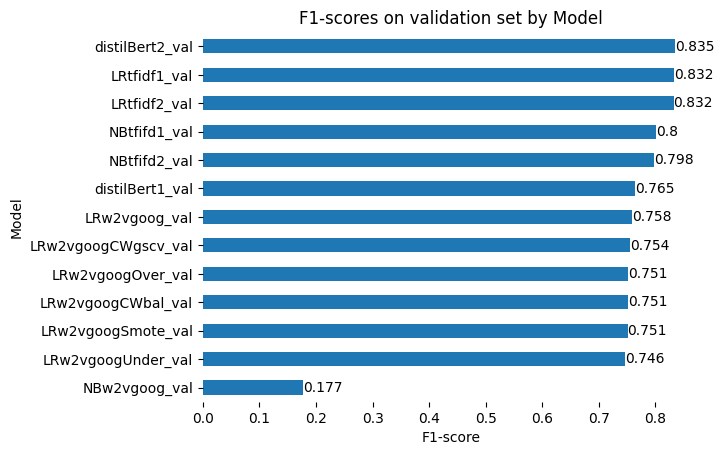

In [3]:
ax = result_df.sort_values("F1-score").plot.barh(x="Model", y="F1-score")
ax.grid=False
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
for i, v in enumerate(result_df["F1-score"].sort_values()):
    ax.text(v, i, str(round(v, 3)), color='black', ha='left', va='center')

ax.set_xlabel("F1-score")
ax.set_ylabel("Model")
ax.set_title("F1-scores on validation set by Model")
ax.legend().remove()
plt.show()

### Predictions on test dataset

Final evaluation on previously unseen test data.

In [14]:
X_test = pickle.load(open("../data/wip/dB/X_test_tot_"+l+".pkl", 'rb'))
y_test = pickle.load(open("../data/wip/dB/y_test_tot_"+l+".pkl", 'rb'))

In [27]:
y_probs = model.predict(X_test)
y_pred_final = []
for prob in y_probs:
    y_pred_final.append(np.argmax(prob))

10268/10268 [==============================] - 1011s 98ms/step


In [29]:
pickle.dump(y_pred_final, open('test_set_preds/results_TEST_SET.pkl','wb'))

In [30]:
res = generate_model_report("test_data_final", y_test, y_pred_final)
report = metrics.classification_report(y_test, y_pred_final, target_names=target_names.values())
print(f'\nFinal classification report on test set:\n{report}')

Accuracy: 0.907110377949976
Precision (macro): 0.8174431974740399
Recall (macro): 0.8762818319157644
F1-score (macro): 0.8344621324911778

Final classification report on test set:
              precision    recall  f1-score   support

     Physics       0.98      0.94      0.96    180999
 Mathematics       0.91      0.91      0.91     71066
Computer Sc.       0.90      0.82      0.86     59196
       Other       0.48      0.84      0.61     17301

    accuracy                           0.91    328562
   macro avg       0.82      0.88      0.83    328562
weighted avg       0.93      0.91      0.91    328562



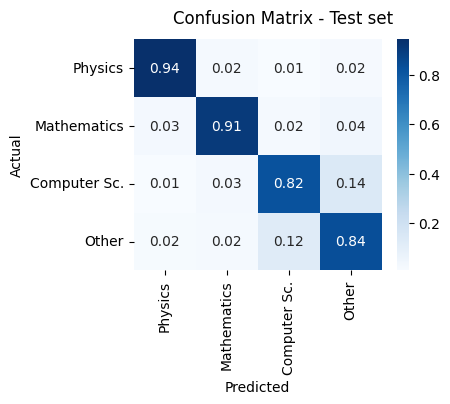

In [57]:
target_names = pickle.load(open("../data/class_labels_dic.pkl", 'rb'))

cm = metrics.confusion_matrix(y_test, y_pred_final)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(4, 3))


sns.heatmap(cm_norm, annot=True, cmap='Blues', fmt='.2f', xticklabels=class_names.values(), yticklabels=target_names.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.suptitle("Confusion Matrix - Test set\n")
plt.show()

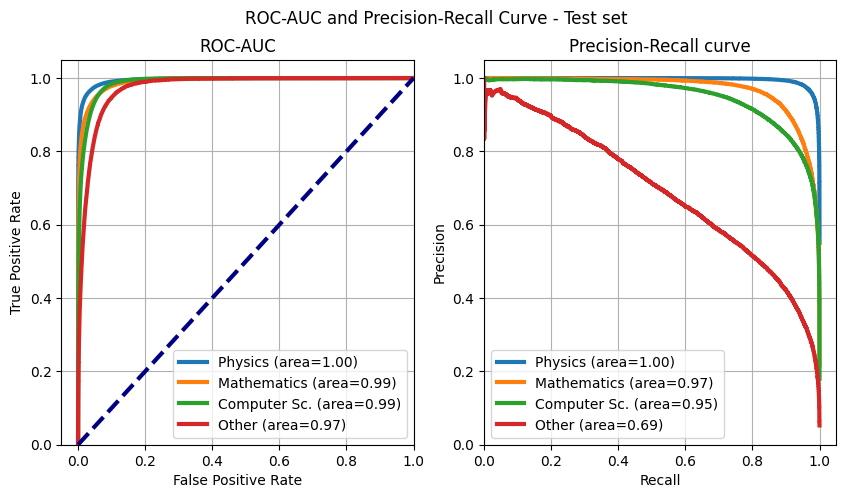

In [56]:
fig, ax = plt.subplots(figsize=(10, 5), nrows=1, ncols=2)

y_test_array = pd.get_dummies(y_test, drop_first=False).values
## roc-auc
for i in range(len(target_names)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           y_probs[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(target_names[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate", 
          title="ROC-AUC")
ax[0].legend(loc="best")
ax[0].grid(True)
    
## precision-recall
for i in range(len(target_names)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], y_probs[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(target_names[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.suptitle("ROC-AUC and Precision-Recall Curve - Test set\n")
plt.show()